# Positional Embeddings in PyTorch

[link](https://ut.philkr.net/deeplearning/transformers/positional_embeddings_in_pytorch/)

In [1]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image

device = torch.device("mps")

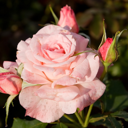

In [2]:
im = Image.open('rose_crop.jpeg').convert('RGB')
im_small = im.resize((128, 128))
im_small

In [3]:
class Rose(nn.Module):
    def __init__(self,enc=nn.Identity(),input_dim=2):
        super().__init__()
        self.enc = enc
        self.net = nn.Sequential(
            nn.Linear(input_dim,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,3)
        )

    def forward(self, x):
        return self.net(self.enc(x))

In [4]:
rose_tensor = torch.as_tensor(np.array(im_small),dtype=torch.float32) / 255. - 0.5
xs = torch.linspace(-1, 1, im_small.size[1])
ys = torch.linspace(-1, 1, im_small.size[0])  

position = torch.stack(
    torch.meshgrid(ys, xs, indexing="ij"),  
    dim=-1,
)
position.shape

torch.Size([128, 128, 2])

## Training

In [5]:
rose_tensor = rose_tensor.to(device)
position = position.to(device)

net = Rose(input_dim=2)
net = net.to(device)
optim = torch.optim.Adam(net.parameters(), lr=1e-3)

for it in range(5000):
    optim.zero_grad()
    loss = abs(net(position)- rose_tensor).mean()
    loss.backward()
    optim.step()
    if it % 100 == 0:
        print(f"Iteration {it}, loss: {loss.item():.6f}")

Iteration 0, loss: 0.326913
Iteration 100, loss: 0.105447
Iteration 200, loss: 0.085817
Iteration 300, loss: 0.076741
Iteration 400, loss: 0.073225
Iteration 500, loss: 0.068046
Iteration 600, loss: 0.067390
Iteration 700, loss: 0.063855
Iteration 800, loss: 0.061581
Iteration 900, loss: 0.059429
Iteration 1000, loss: 0.058433
Iteration 1100, loss: 0.059050
Iteration 1200, loss: 0.058243
Iteration 1300, loss: 0.055254
Iteration 1400, loss: 0.057607
Iteration 1500, loss: 0.056006
Iteration 1600, loss: 0.053176
Iteration 1700, loss: 0.052152
Iteration 1800, loss: 0.053235
Iteration 1900, loss: 0.051279
Iteration 2000, loss: 0.051966
Iteration 2100, loss: 0.049866
Iteration 2200, loss: 0.052537
Iteration 2300, loss: 0.049136
Iteration 2400, loss: 0.053320
Iteration 2500, loss: 0.049010
Iteration 2600, loss: 0.048246
Iteration 2700, loss: 0.048417
Iteration 2800, loss: 0.048111
Iteration 2900, loss: 0.047891
Iteration 3000, loss: 0.048298
Iteration 3100, loss: 0.048357
Iteration 3200, loss

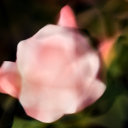

In [6]:
Image.fromarray(((net(position)+0.5).clamp(0,1).cpu().detach().numpy()*255).astype(np.uint8))

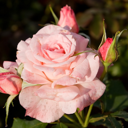

In [7]:
im_small

## Let's use a better position encoding

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self,embed_dim):
        super().__init__()
        self.freq = torch.exp(torch.arange(0,embed_dim,2)/2)
        self.embed_dim = embed_dim

    def forward(self, x):
        x = x[..., None,:] * self.freq[..., None].to(x.device)
        return torch.cat([torch.sin(x),torch.cos(x)] , dim=-1).view(*x.shape[:-2], -1)

## Embedding Visualization

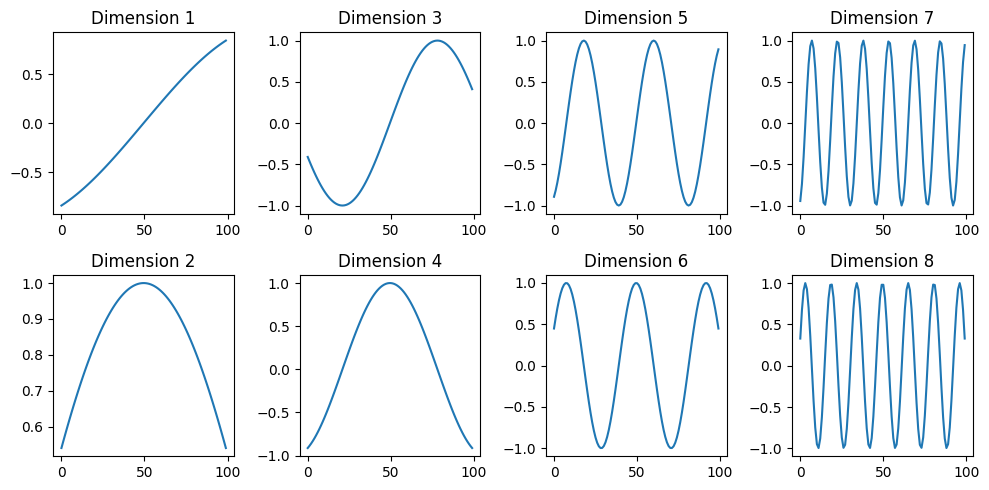

In [9]:
from matplotlib import pyplot as plt
fig,ax = plt.subplots(2,4,figsize=(10,5))
pe = PositionalEncoding(embed_dim=8)
e = pe(torch.linspace(-1,1,100)[:,None])

for i in range(8):
    r, c = i % 2, i // 2
    ax[r, c].plot(e[:, i].numpy())
    ax[r, c].set_title(f"Dimension {i+1}")

plt.tight_layout() 
plt.show()

## Training

In [10]:
rose_tensor = rose_tensor.to(device)
position = position.to(device)

net = Rose(enc=PositionalEncoding(embed_dim=12), input_dim=12*2)
net = net.to(device)
optim = torch.optim.Adam(net.parameters(), lr=1e-3)

for it in range(5000):
    optim.zero_grad()
    loss = abs(net(position) - rose_tensor).mean()
    loss.backward()
    optim.step()
    if it % 100 == 0:
        print(f"Iteration {it}, loss: {loss.item():.6f}")

Iteration 0, loss: 0.349685
Iteration 100, loss: 0.066526
Iteration 200, loss: 0.042494
Iteration 300, loss: 0.033178
Iteration 400, loss: 0.028893
Iteration 500, loss: 0.025557
Iteration 600, loss: 0.024057
Iteration 700, loss: 0.022763
Iteration 800, loss: 0.022542
Iteration 900, loss: 0.019525
Iteration 1000, loss: 0.021700
Iteration 1100, loss: 0.020884
Iteration 1200, loss: 0.017673
Iteration 1300, loss: 0.017804
Iteration 1400, loss: 0.017768
Iteration 1500, loss: 0.017164
Iteration 1600, loss: 0.016677
Iteration 1700, loss: 0.016738
Iteration 1800, loss: 0.015506
Iteration 1900, loss: 0.015984
Iteration 2000, loss: 0.014891
Iteration 2100, loss: 0.016228
Iteration 2200, loss: 0.014041
Iteration 2300, loss: 0.013735
Iteration 2400, loss: 0.014853
Iteration 2500, loss: 0.013344
Iteration 2600, loss: 0.013410
Iteration 2700, loss: 0.015132
Iteration 2800, loss: 0.014039
Iteration 2900, loss: 0.014638
Iteration 3000, loss: 0.013869
Iteration 3100, loss: 0.012813
Iteration 3200, loss

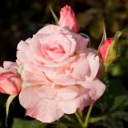

In [11]:
Image.fromarray(((net(position)+0.5).clamp(0,1).cpu().detach().numpy()*255).astype(np.uint8))

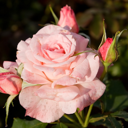

In [12]:
im_small

## Generalization

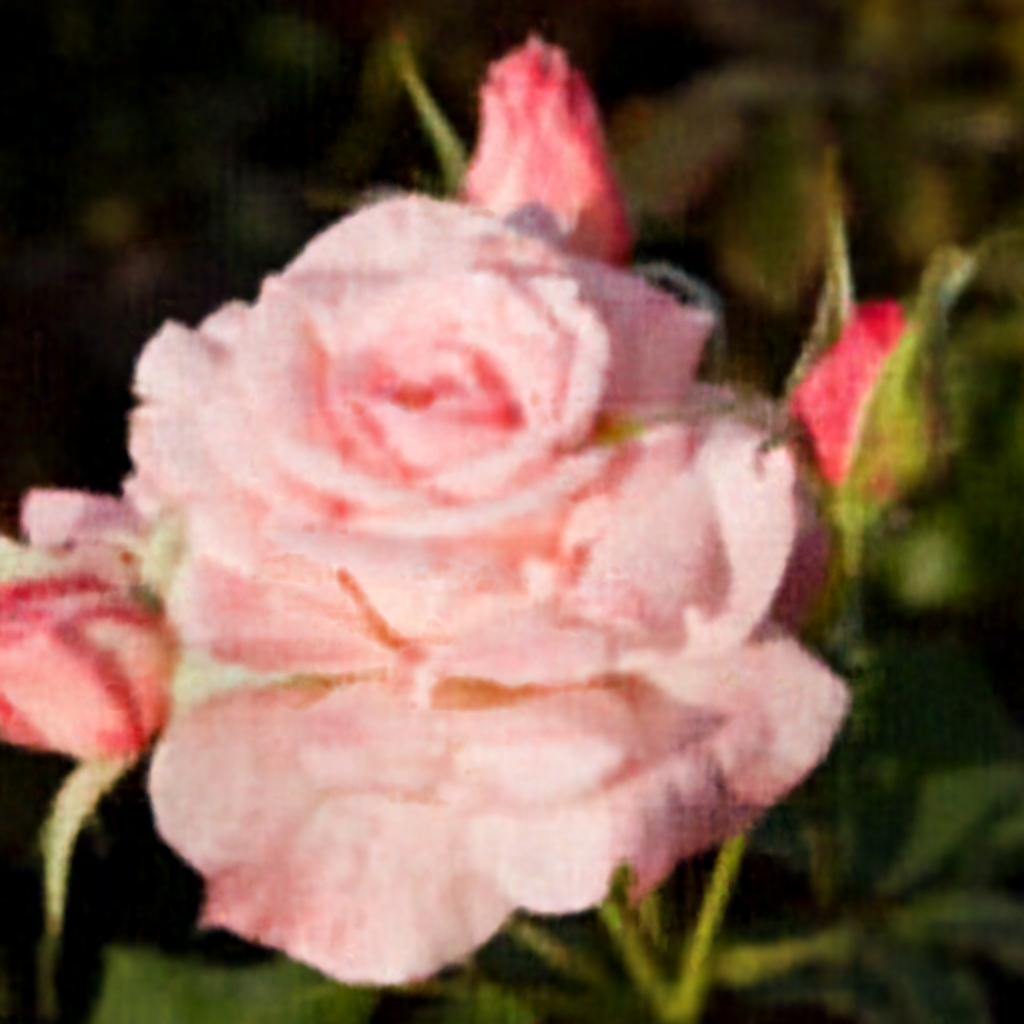

In [13]:
xs_h = torch.linspace(-1, 1, 1024)
ys_h = torch.linspace(-1, 1, 1024)  

position_hires = torch.stack(
    torch.meshgrid(ys_h, xs_h, indexing="ij"),  
    dim=-1,
).to(device)

Image.fromarray(((net(position_hires)+0.5).clamp(0,1).cpu().detach().numpy()*255).astype(np.uint8))